In [1]:
import matplotlib.pyplot as plt
import cv2 as cv

import os
import re

logs = '/mnt/DADES/home/pmedina/tfg/src/raw_runs/logs/'

In [46]:
# Your pre-defined functions
def position_accuracy(prediction, ground_truth):
    max_len = max(len(prediction), len(ground_truth))
    diff_count = 0

    # Compare overlapping characters
    for c1, c2 in zip(prediction, ground_truth):
        if c1 != c2:
            diff_count += 1

    # Add difference for extra characters in the longer string
    diff_count += abs(len(prediction) - len(ground_truth))

    difference_percentage = (diff_count / max_len) if max_len > 0 else 0
    return difference_percentage

def strict_accuracy(prediction, ground_truth):
    return prediction == ground_truth

def character_level(prediction, ground_truth):
    """
    Return both the character-level accuracy and recall for characters that are
    in prediction and match in ground truth.
    """
    prediction_chars = [char for char in prediction]
    ground_truth_chars = [char for char in ground_truth]

    # Count number of correct matches
    correct_matches = sum(1 for char in prediction_chars if char in ground_truth_chars)
    
    # Precision: how many characters predicted correctly in prediction
    precision = correct_matches / len(prediction_chars) if prediction_chars else 0
    
    # Recall: how many characters predicted correctly in ground truth
    recall = correct_matches / len(ground_truth_chars) if ground_truth_chars else 0
    
    # Character accuracy as previously defined
    accuracy = precision  # Accuracy can be considered the same as precision here for this task

    return accuracy, recall

# Example
ground_truth = "09/2023H2022L2272029502"
prediction =   "09/2023H2022L2272024sdaewaea2323213402"  # change this to test differences

diff_percent = strict_accuracy(prediction, ground_truth)
# print(f"Character similarity: {100 - diff_percent:.2f}%")
print(character_level(ground_truth, prediction))

(0.9565217391304348, 0.5789473684210527)


In [2]:
import editdistance
from collections import Counter

def character_error_rate(prediction, ground_truth):
    """
    CER = (Substitutions + Insertions + Deletions) / len(ground_truth)
    """
    if not ground_truth:
        return 1.0 if prediction else 0.0
    distance = editdistance.eval(prediction, ground_truth)
    return distance / len(ground_truth)

def levenshtein_similarity(prediction, ground_truth):
    if not prediction and not ground_truth:
        return 1.0
    distance = editdistance.eval(prediction, ground_truth)
    max_len = max(len(prediction), len(ground_truth))
    return 1.0 - (distance / max_len)

def strict_accuracy(prediction, ground_truth):
    return 1 if prediction == ground_truth else 0

def char_level_metrics(prediction, ground_truth):
    pred_counter = Counter(prediction)
    gt_counter = Counter(ground_truth)

    # True Positives: sum of min match counts
    tp = sum(min(pred_counter[char], gt_counter[char]) for char in pred_counter)

    precision = tp / len(prediction) if prediction else 0
    recall = tp / len(ground_truth) if ground_truth else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1


In [8]:
results = {}

for file in os.listdir(logs):
    actual_file = file.split('.')[0]
    total_time = 0
    correct_predictions = 0
    incorrect_predictions = 0
    cer_list = []
    strict_acc_list = []
    char_precision_list = []
    char_recall_list = []

    results[actual_file] = {
        'total_time': 0,
        'time_per_code': 0,
        'strict_accuracy': 0,
        'character_error_rate': 0,
        'character_precision': 0,
        'character_recall': 0,
        'correct_predictions': 0,
        'incorrect_predictions': 0
    }

    with open(logs + file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            parts = line.strip().split(';')
            if len(parts) != 4:
                continue

            id_, time, ground_truth, prediction = parts
            ground_truth = ''.join(re.sub(r'\:', '', ground_truth).split(' '))
            prediction = ''.join(prediction.split(' '))

            total_time += float(time)

            strict = strict_accuracy(prediction, ground_truth)
            cer = character_error_rate(prediction, ground_truth)
            precision, recall, _ = char_level_metrics(prediction, ground_truth)

            strict_acc_list.append(strict)
            cer_list.append(cer)
            char_precision_list.append(precision)
            char_recall_list.append(recall)

            if strict:
                correct_predictions += 1
            else:
                incorrect_predictions += 1

        # Aggregate results
        results[actual_file]['total_time'] = round(total_time, 4)
        results[actual_file]['time_per_code'] = round(total_time / len(lines), 4) if len(lines) > 0 else 0
        results[actual_file]['strict_accuracy'] = sum(strict_acc_list) / len(strict_acc_list) * 100 if strict_acc_list else 0
        results[actual_file]['character_error_rate'] = sum(cer_list) / len(cer_list) * 100 if cer_list else 0
        results[actual_file]['character_precision'] = sum(char_precision_list) / len(char_precision_list) * 100 if char_precision_list else 0
        results[actual_file]['character_recall'] = sum(char_recall_list) / len(char_recall_list) * 100 if char_recall_list else 0
        results[actual_file]['correct_predictions'] = correct_predictions
        results[actual_file]['incorrect_predictions'] = incorrect_predictions

# --- Print Results ---

for file, result in results.items():
    if 'CPU' in file:
        print(f"Results for {file}:")
        print(f"  Total Time: {result['total_time']}s")
        print(f"  Time per Code: {result['time_per_code']}s")
        print(f"  Strict Accuracy: {result['strict_accuracy']:.2f}%")
        print(f"  Character Error Rate (CER): {result['character_error_rate']:.2f}%")
        print(f"  Character-Level Precision: {result['character_precision']:.2f}%")
        print(f"  Character-Level Recall: {result['character_recall']:.2f}%")
        print(f"  Correct Predictions: {result['correct_predictions']}")
        print(f"  Incorrect Predictions: {result['incorrect_predictions']}")
        print("--------------------------")

Results for paddleOCR_timeLogCPU:
  Total Time: 162.0295s
  Time per Code: 0.0955s
  Strict Accuracy: 0.00%
  Character Error Rate (CER): 16.55%
  Character-Level Precision: 86.39%
  Character-Level Recall: 93.54%
  Correct Predictions: 0
  Incorrect Predictions: 1695
--------------------------
Results for TrOCR_timeLogCPU:
  Total Time: 253.4593s
  Time per Code: 0.1494s
  Strict Accuracy: 0.00%
  Character Error Rate (CER): 72.56%
  Character-Level Precision: 69.15%
  Character-Level Recall: 42.42%
  Correct Predictions: 0
  Incorrect Predictions: 1696
--------------------------
Results for easyOCR_timeLogCPU:
  Total Time: 322.99s
  Time per Code: 0.1904s
  Strict Accuracy: 0.39%
  Character Error Rate (CER): 18.91%
  Character-Level Precision: 85.51%
  Character-Level Recall: 94.31%
  Correct Predictions: 6
  Incorrect Predictions: 1529
--------------------------


In [5]:
print(len(os.listdir("/mnt/DADES/home/pmedina/tfg/data/preprocessed_images")))

1696


In [ ]:
# results = {}

# for file in os.listdir(logs):
#     actual_file = file.split('.')[0]
#     total_time = 0
#     correct_predictions = 0
#     incorrect_predictions = 0
#     position_acc_list = []
#     strict_acc_list = []
#     char_acc_list = []
#     recall_list = []

#     # Initialize result structure for each file
#     results[actual_file] = {
#         'total_time': 0,
#         'time_per_code': 0,
#         'strict_accuracy': 0,
#         'position_accuracy': 0,
#         'character_accuracy': 0,
#         'character_accuracy_recall': 0,
#         'correct_predictions': 0,
#         'incorrect_predictions': 0
#     }

#     with open(logs + file, 'r') as f:
#         lines = f.readlines()

#         for line in lines:
#             parts = line[:-1].split(';')
#             if len(parts) != 4:
#                 # Skip the line if it doesn't have exactly 4 parts
#                 continue

#             id_, time, ground_truth, prediction = parts
#             ground_truth = ''.join(re.sub(r'\:', '', ground_truth).split(' '))
#             prediction = ''.join(prediction.split(' '))

#             # Update total time
#             total_time += float(time)

#             # Calculate the different accuracies
#             strict = strict_accuracy(prediction, ground_truth)
#             pos_acc = position_accuracy(prediction, ground_truth)
#             char_acc, recall = character_level(prediction, ground_truth)

#             # Store accuracy results for later aggregation
#             strict_acc_list.append(strict)
#             position_acc_list.append(pos_acc)
#             char_acc_list.append(char_acc)
#             recall_list.append(recall)

#             # Increment correct/incorrect predictions
#             if ground_truth == prediction:
#                 correct_predictions += 1
#             else:
#                 incorrect_predictions += 1

#         # Calculate aggregated statistics for this file
#         results[actual_file]['total_time'] = round(total_time, 4)
#         results[actual_file]['time_per_code'] = round(total_time / len(lines), 4) if len(lines) > 0 else 0
#         results[actual_file]['strict_accuracy'] = sum(strict_acc_list) / len(strict_acc_list)*100 if strict_acc_list else 0
#         results[actual_file]['position_accuracy'] = sum(position_acc_list) / len(position_acc_list)*100 if position_acc_list else 0
#         results[actual_file]['character_accuracy'] = sum(char_acc_list) / len(char_acc_list)*100 if char_acc_list else 0
#         results[actual_file]['character_accuracy_recall'] = sum(recall_list) / len(recall_list)*100 if recall_list else 0
#         results[actual_file]['correct_predictions'] = correct_predictions
#         results[actual_file]['incorrect_predictions'] = incorrect_predictions

# # Output the results (example printout)
# for file, result in results.items():
#     print(f"Results for {file}:")
#     print(f"  Total Time: {result['total_time']}s")
#     print(f"  Time per Code: {result['time_per_code']}s")
#     print(f"  Strict Accuracy: {result['strict_accuracy']:.2f}%")
#     print(f"  Position Accuracy: {result['position_accuracy']:.2f}%")
#     print(f"  Character Accuracy: {result['character_accuracy']:.2f}%")
#     print(f"  Character Accuracy Recall: {result['character_accuracy_recall']:.2f}%")
#     print(f"  Correct Predictions: {result['correct_predictions']}")
#     print(f"  Incorrect Predictions: {result['incorrect_predictions']}")
#     print("--------------------------")

Results for paddleOCR_timeLogGPU:
  Total Time: 47.3393s
  Time per Code: 0.0279s
  Strict Accuracy: 2.18%
  Position Accuracy: 60.84%
  Character Accuracy: 93.08%
  Character Accuracy Recall: 97.61%
  Correct Predictions: 37
  Incorrect Predictions: 1659
--------------------------
Results for easyOCR_timeLogGPU:
  Total Time: 74.5186s
  Time per Code: 0.0439s
  Strict Accuracy: 0.60%
  Position Accuracy: 64.99%
  Character Accuracy: 86.23%
  Character Accuracy Recall: 89.67%
  Correct Predictions: 9
  Incorrect Predictions: 1481
--------------------------


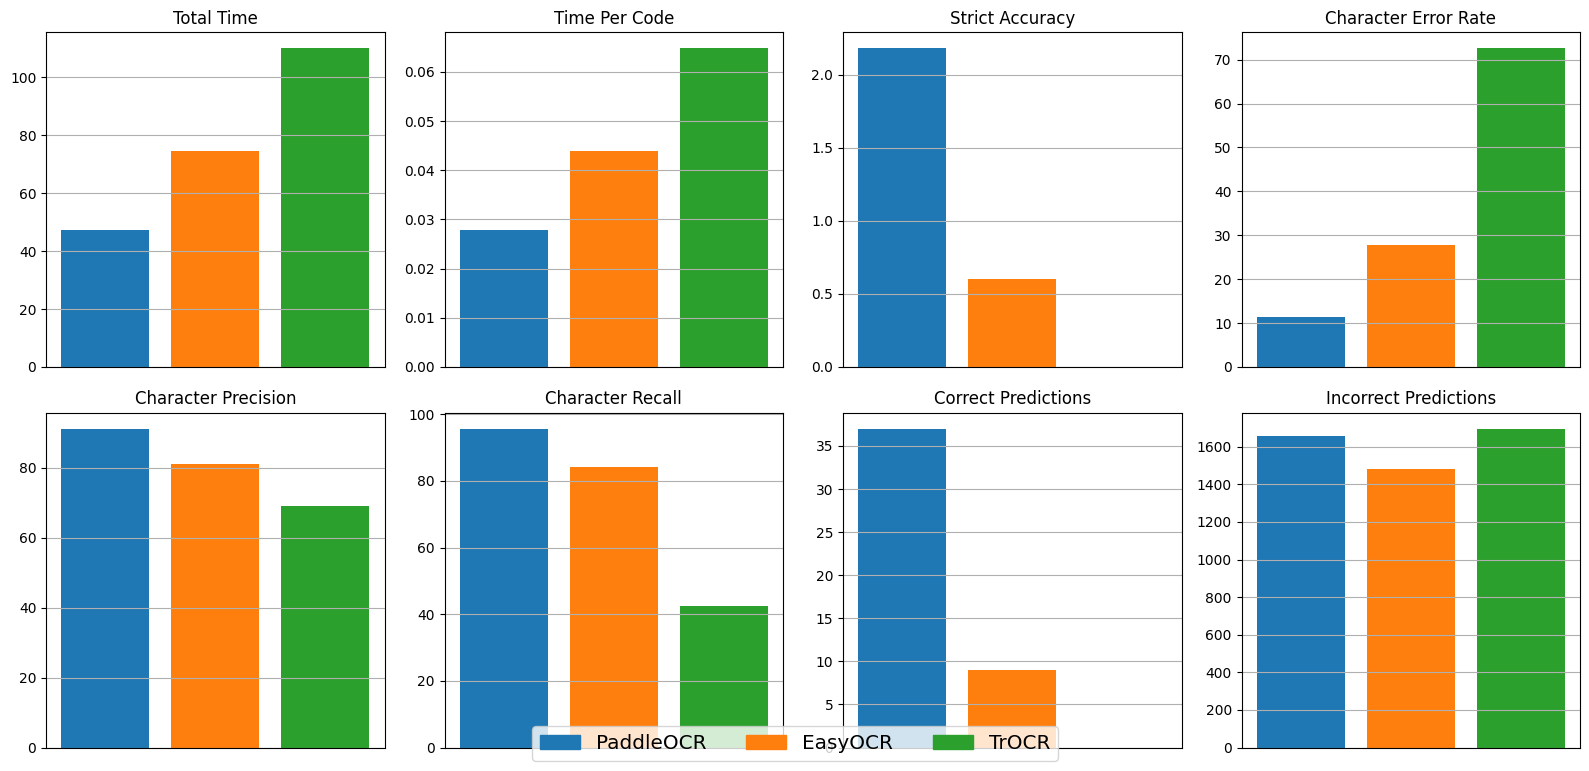

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir el orden y colores de los modelos
model_order = ['PaddleOCR', 'EasyOCR', 'TrOCR']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Renombrar claves en el diccionario para facilitar uso
results['PaddleOCR'] = results['paddleOCR_timeLogGPU']
results['EasyOCR'] = results['easyOCR_timeLogGPU']
results['TrOCR'] = results['TrOCR_timeLogGPU']

# Extraer las métricas
metrics = list(next(iter(results.values())).keys())

# Crear subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

x = np.arange(len(model_order))  # posiciones en el eje x

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in model_order]

    # Barras individuales con color por modelo
    for j, (val, color) in enumerate(zip(values, colors)):
        axes[i].bar(j, val, color=color, label=model_order[j])

    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].set_xticks([])  # Quitar etiquetas del eje X
    axes[i].grid(True, axis='y')

# Añadir leyenda solo una vez, fuera del loop
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
fig.legend(handles, model_order, loc='lower center', ncol=3, fontsize='x-large')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # espacio para la leyenda superior
plt.savefig('results')
plt.show()


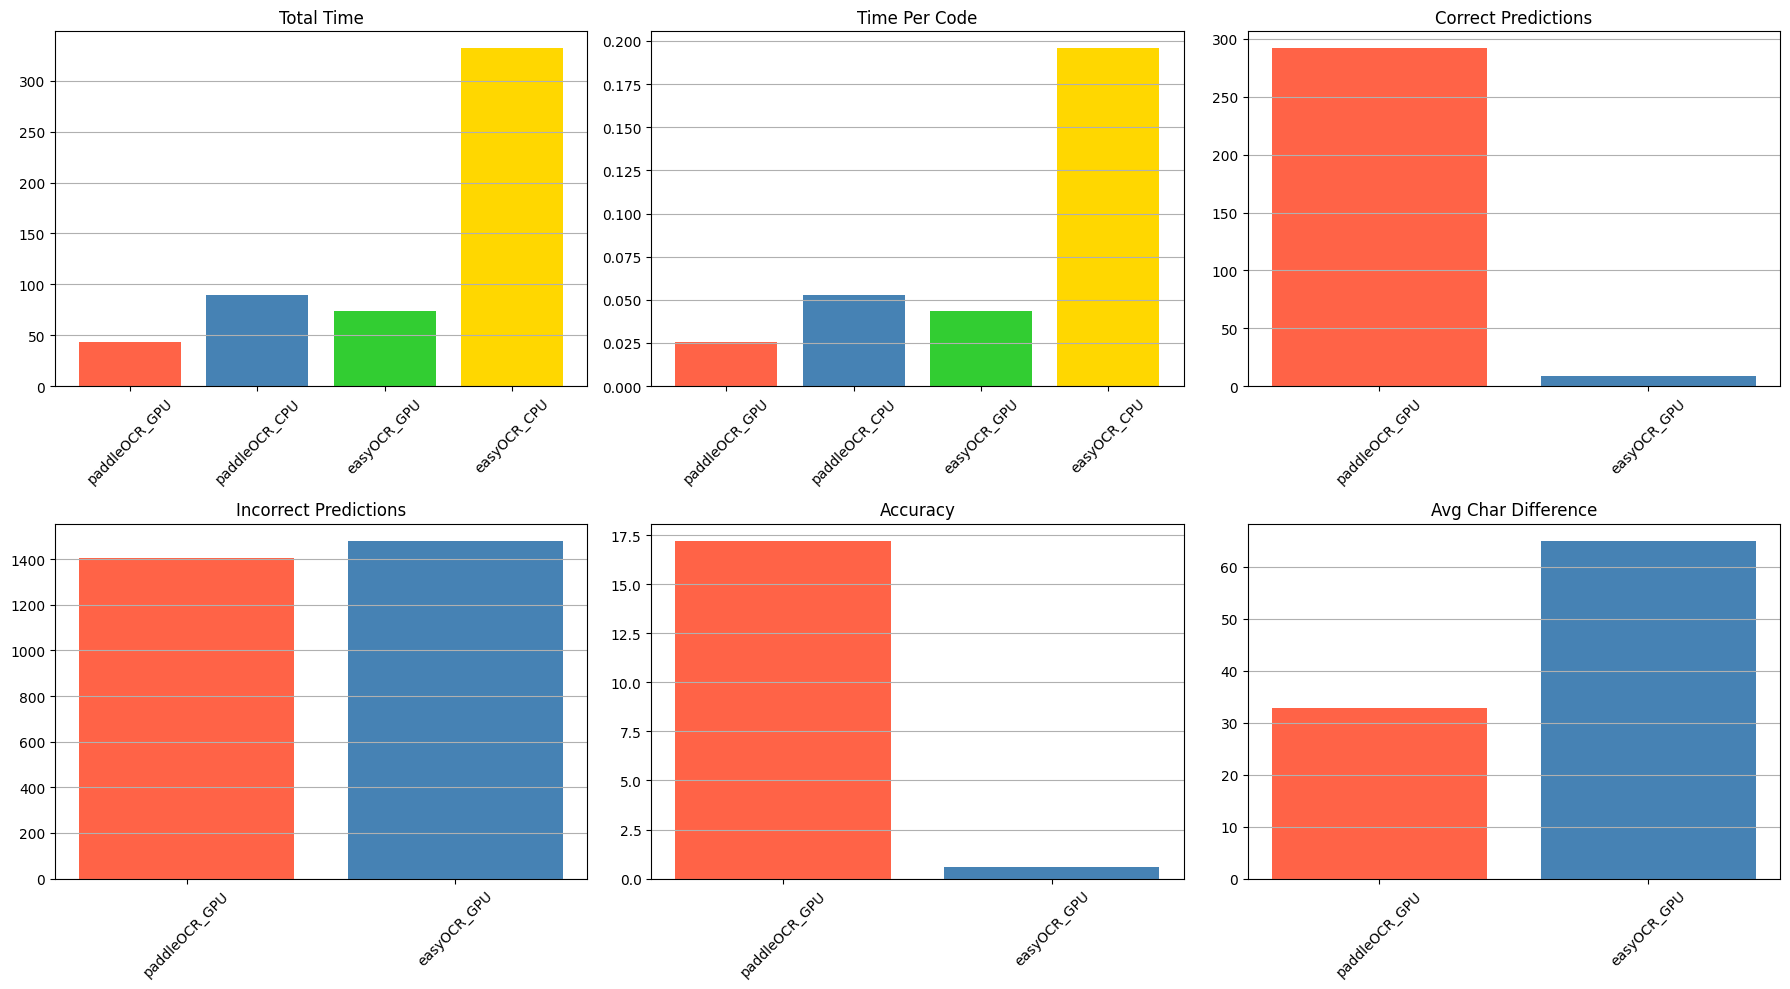

In [52]:
import matplotlib.pyplot as plt

# Define the specific order for the models and the colors
model_order = ['paddleOCR_GPU', 'paddleOCR_CPU', 'easyOCR_GPU', 'easyOCR_CPU']
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']  # Different colors for each bar

# Extract the list of metrics to plot
metrics = ['total_time', 'time_per_code', 'correct_predictions', 'incorrect_predictions', 'accuracy', 'avg_char_difference']

# Prepare the data for plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if metric == 'time_per_code' or metric == 'total_time':
        # For time_per_code and total_time, plot all 4 models
        values = [results[model][metric] for model in model_order]
        labels = model_order
        ax_color = colors  # Assign colors to all models
    else:
        # For other metrics, only plot for GPU models
        values = [results[model][metric] for model in ['paddleOCR_GPU', 'easyOCR_GPU']]
        labels = ['paddleOCR_GPU', 'easyOCR_GPU']
        ax_color = ['#FF6347', '#4682B4']  # Assign custom colors for just the GPU models

    axes[i].bar(labels, values, color=ax_color)
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y')

plt.tight_layout()
plt.show()
